# Задание 1. Линейная регрессия
Датасет: https://www.kaggle.com/datasets/iamsouravbanerjee/house-rent-prediction-dataset
Для приведенного выше датасета, построить модель линейной регрессии для
оценивания стоимости аренды недвижимости. Для решения задачи предлагается
использовать следующие подходы:
1. Получить решение задачи в замкнутом виде с помощью псевдообратной
матрицы. Рассмотреть случаи без регуляризации и с 𝐿2 регуляризацией.
2. Получить решение задачи методом градиентного спуска. Получить формулу
для градиента, используя матрицу признаков. Сравнить полученные решениданном примере?

При решении задачи необходимо ответить на следующие вопросы:
1. Какие признаки оказывают наибольший вклад в точность определения
стоимости аренды? Предложить способы отбора наиболее важных признаков
2. Какая модель имеет наименьшее значение функции потерь на тестовой
выборке? Помогает ли регуляризация избежать эффекта переобучения в
данном примере?

### Пояснения
BHK: Number of Bedrooms, Hall, Kitchen.

Rent: Rent of the Houses/Apartments/Flat.

Size: Size of the Houses/Apartments/Flats in Square Fet.

Floor: Houses/Apartments/Flats situated in which Floor and Total Number of Floors (Example: Ground out of 2, 3 out of 5,etc.)

Area Type: Size of the Houses/Apartments/Flats calculated on either Super Area or Carpet Area or Buid Area.

Area Locality: Locality of the Houses/Apartmets/Flats.

City: City where the Houses/Apartments/Flats are Located.

Furnishing Status: Furnishing Status of the Houses/Apartments/Flats, either it is Furnished or Semi-Furnished or Unfurnished.

Tenant Preferred: Type of Tenant Preferred by the Owner or Agent.

Bathroom: Number of Bathrooms.

Point of Contact: Whom should you contact for more information regarding the Houses/Apartments/Flats.

In [1]:
import pandas as pd

data = pd.read_csv("D:/Projects/University/ML/Task1/House_Rent_Dataset.csv")

data.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


In [2]:
# Информация о данных, типы признаков, пропущенные значения
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Posted On          4746 non-null   object
 1   BHK                4746 non-null   int64 
 2   Rent               4746 non-null   int64 
 3   Size               4746 non-null   int64 
 4   Floor              4746 non-null   object
 5   Area Type          4746 non-null   object
 6   Area Locality      4746 non-null   object
 7   City               4746 non-null   object
 8   Furnishing Status  4746 non-null   object
 9   Tenant Preferred   4746 non-null   object
 10  Bathroom           4746 non-null   int64 
 11  Point of Contact   4746 non-null   object
dtypes: int64(4), object(8)
memory usage: 445.1+ KB


In [3]:
# Базовая статистика
data.describe()

,BHK,Rent,Size,Bathroom
count,4746.000000,4.746000e+03,4746.000000,4746.000000
mean,2.083860,3.499345e+04,967.490729,1.965866
std,0.832256,7.810641e+04,634.202328,0.884532
min,1.000000,1.200000e+03,10.000000,1.000000
25%,2.000000,1.000000e+04,550.000000,1.000000
50%,2.000000,1.600000e+04,850.000000,2.000000
75%,3.000000,3.300000e+04,1200.000000,2.000000
max,6.000000,3.500000e+06,8000.000000,10.000000


Рассмотрим подробнее все признаки и попытаемся выявить только те, которые необходимо использовать в рамках задачи. Для начала определим количество возможных принимаемых значений у нечисленных фич и отбросим те, которые принимают слишком много значений.

In [4]:
# Определение численных и нечисленных фичей на уровне всего датасета
numeric_features = data.select_dtypes(include=['number']).columns
categorical_features = data.select_dtypes(exclude=['number']).columns

# Вывод количества уникальных значений для нечисленных фичей
for column in categorical_features:
    unique_values_count = data[column].nunique()
    print(f"Численная фича '{column}' имеет {unique_values_count} уникальных значений.")

Численная фича 'Posted On' имеет 81 уникальных значений.
Численная фича 'Floor' имеет 480 уникальных значений.
Численная фича 'Area Type' имеет 3 уникальных значений.
Численная фича 'Area Locality' имеет 2235 уникальных значений.
Численная фича 'City' имеет 6 уникальных значений.
Численная фича 'Furnishing Status' имеет 3 уникальных значений.
Численная фича 'Tenant Preferred' имеет 3 уникальных значений.
Численная фича 'Point of Contact' имеет 3 уникальных значений.


### Posted On
Данная фича скорее всего не влияет или же влияет мало на наше исследование. Можем отбросить.

### Floor
Этот признак содержит в себе общее кол-во этажей в здании и этаж апартаментов. Для упрощения отбрасываем.

### Area Locality
Слишком много значений, убираем.

In [5]:
# Удаление указанных фичей из датасета
columns_to_drop = ['Posted On', 'Floor', 'Area Locality']
data = data.drop(columns=columns_to_drop, axis=1)

### Преобразование категорий в бинарные векторы
Теперь для выполнения линейной регрессии необходимо либо преобразовать категориальные признаки в числовые, либо преобразовать их в бинарные векторы. Остановимся на втором варианте.

In [6]:
# Определение категориальных фичей
categorical_features = ['Area Type', 'City', 'Furnishing Status', 'Tenant Preferred', 'Point of Contact']

# Применение One-Hot Encoding
target_variable = data['Rent']
data = data.drop(columns=['Rent'], axis=1)
features_to_use = pd.get_dummies(data, columns=categorical_features)
features_to_use

,BHK,Size,Bathroom,Area Type_Built Area,Area Type_Carpet Area,Area Type_Super Area,City_Bangalore,City_Chennai,City_Delhi,City_Hyderabad,...,City_Mumbai,Furnishing Status_Furnished,Furnishing Status_Semi-Furnished,Furnishing Status_Unfurnished,Tenant Preferred_Bachelors,Tenant Preferred_Bachelors/Family,Tenant Preferred_Family,Point of Contact_Contact Agent,Point of Contact_Contact Builder,Point of Contact_Contact Owner
0,2,1100,2,0,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
1,2,800,1,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
2,2,1000,1,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
3,2,800,1,0,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
4,2,850,1,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4741,2,1000,2,0,1,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,1
4742,3,2000,3,0,0,1,0,0,0,1,...,0,0,1,0,0,1,0,0,0,1
4743,3,1750,3,0,1,0,0,0,0,1,...,0,0,1,0,0,1,0,1,0,0
4744,3,1500,2,0,1,0,0,0,0,1,...,0,0,1,0,0,0,1,1,0,0


### Решение задачи в замкнутом виде с помощью псевдообратной матрицы без регуляризации

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Разделение на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(features_to_use, target_variable, test_size=0.2, random_state=42)

# Скейлер
scaler = StandardScaler()

# Применить скейл к признакам
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
    
def calculate_solution(X_train, y_train,lambda_reg=None):
    X_train_with_constant = np.column_stack((np.ones(len(X_train)), X_train))

    if lambda_reg is None:
        # Расчет параметров модели с помощью псевдообратной матрицы
        theta = np.linalg.pinv(X_train_with_constant) @ y_train
    else:
        # Расчет параметров модели с L2-регуляризацией
        theta = np.linalg.inv(X_train_with_constant.T @ X_train_with_constant + lambda_reg * np.eye(X_train_with_constant.shape[1])) @ X_train_with_constant.T @ y_train
    
    # Извлечение intercept и коэффициентов (весов)
    intercept = theta[0]
    weights = theta[1:]

    return intercept, weights, theta

intercept, weights, theta = calculate_solution(X_train, y_train)

# Вывод параметров модели
print("Intercept (свободный член):", intercept)
print("Weights (веса):", weights)

# Предсказание на тестовом наборе
X_test_with_constant = np.column_stack((np.ones(len(X_test)), X_test))
y_pred = X_test_with_constant @ theta

# Вычисление среднеквадратичной ошибки
mse = mean_squared_error(y_test, y_pred)

# Вывод среднеквадратичной ошибки
print("\nСреднеквадратичная ошибка (MSE):", mse)

Intercept (свободный член): 35151.51633298205
Weights (веса): [ 3077.63312586 23244.58228055 10195.10330566   190.97499168
   746.16853152  -754.91245785 -2334.84694702 -5385.49018439
   433.34812394 -8751.83706058 -2750.02075637 17615.41575592
  2332.41346447  -962.87176378  -684.06454781  1029.37316339
   862.05581479 -2607.69223768  2184.83474221   471.91952593
 -2200.75424359]

Среднеквадратичная ошибка (MSE): 1911180916.2022083


### Решение задачи в замкнутом виде с помощью псевдообратной матрицы с L2 регуляризацией

In [8]:
intercept, weights, theta = calculate_solution(X_train, y_train, 0.1)

# Вывод параметров модели
print("Intercept (свободный член):", intercept)
print("Weights (веса):", weights)

# Предсказание на тестовом наборе
X_test_with_constant = np.column_stack((np.ones(len(X_test)), X_test))
y_pred = X_test_with_constant @ theta

# Вычисление среднеквадратичной ошибки
mse = mean_squared_error(y_test, y_pred)

# Вывод среднеквадратичной ошибки
print("\nСреднеквадратичная ошибка (MSE):", mse)

Intercept (свободный член): 35150.590342720185
Weights (веса): [ 3078.33787598 23243.00165849 10195.33294284   190.96017715
   746.19018868  -754.93343434 -2334.65454625 -5385.250809
   433.1618256  -8751.39617587 -2749.94176483 17614.66879436
  2332.46827683  -962.85094129  -684.12523801  1029.32061116
   862.0320027  -2607.58937062  2185.11226757   471.88398609
 -2201.03047518]

Среднеквадратичная ошибка (MSE): 1911189769.349098


### Получить решение задачи методом градиентного спуска. Получить формулу для градиента, используя матрицу признаков..

#### Градиентный спуск без регуляризации.

In [9]:
import numpy as np

def gradient_descent(X_train, y_train, learning_rate=0.01, num_iterations=1000, lambda_reg=None):
    m, n = X_train.shape
    theta = np.zeros(n)  # Инициализация параметров модели нулевыми значениями
    cost_history = []

    for _ in range(num_iterations):
        # Вычисление предсказаний модели
        predictions = np.dot(X_train, theta)

        # Проверка на наличие NaN в предсказаниях
        if np.isnan(predictions).any():
            raise ValueError("NaN values detected in predictions. Gradient descent did not converge.")
        
        # Вычисление ошибки
        errors = predictions - y_train

        # Обновление параметров модели с использованием градиента
        gradient = (np.dot(X_train.T, errors) + lambda_reg * theta) / m if lambda_reg is not None else np.dot(X_train.T, errors) / m
        theta -= learning_rate * gradient

        # Вычисление функции потерь (среднеквадратичной ошибки) с учетом L2-регуляризации
        cost = (np.sum(errors**2) + lambda_reg * np.sum(theta[1:]**2)) / (2 * m) if lambda_reg is not None else np.sum(errors**2) / (2 * m)
        cost_history.append(cost)

    return theta, cost_history


def calculate_solution_gradient_descent(X_train, y_train, learning_rate=0.01, num_iterations=1000, lambda_reg=None):
    X_train_with_constant = np.column_stack((np.ones(len(X_train)), X_train))
    
    # Запуск градиентного спуска
    theta, cost_history = gradient_descent(X_train_with_constant, y_train, learning_rate, num_iterations, lambda_reg)

    # Извлечение intercept и весов (weights)
    intercept = theta[0]
    weights = theta[1:]

    return intercept, weights, theta

intercept, weights, theta = calculate_solution_gradient_descent(X_train, y_train, num_iterations=10000)

# Вывод параметров модели
print("Intercept (свободный член):", intercept)
print("Weights (веса):", weights)

# Предсказание на тестовом наборе
X_test_with_constant = np.column_stack((np.ones(len(X_test)), X_test))
y_pred = X_test_with_constant @ theta

# Вычисление среднеквадратичной ошибки
mse = mean_squared_error(y_test, y_pred)

# Вывод среднеквадратичной ошибки
print("\nСреднеквадратичная ошибка (MSE):", mse)

Intercept (свободный член): 35151.51633298173
Weights (веса): [ 3077.63308242 23244.58226257 10195.10336809   190.97499157
   746.16853175  -754.91245807 -2334.84694516 -5385.490184
   433.34812589 -8751.83706089 -2750.02074663 17615.41574494
  2332.41346443  -962.87176375  -684.06454781  1029.37316273
   862.0558151  -2607.6922373   2184.83474262   471.91952585
 -2200.754244  ]

Среднеквадратичная ошибка (MSE): 1911180916.3190491


#### Градиентный спуск c L2 регуляризацией.

In [11]:
intercept, weights, theta = calculate_solution_gradient_descent(X_train, y_train, num_iterations=10000, lambda_reg=0.1)

# Вывод параметров модели
print("Intercept (свободный член):", intercept)
print("Weights (веса):", weights)

# Предсказание на тестовом наборе
X_test_with_constant = np.column_stack((np.ones(len(X_test)), X_test))
y_pred = X_test_with_constant @ theta

# Вычисление среднеквадратичной ошибки
mse = mean_squared_error(y_test, y_pred)

# Вывод среднеквадратичной ошибки
print("\nСреднеквадратичная ошибка (MSE):", mse)

Intercept (свободный член): 35150.590342719806
Weights (веса): [ 3078.33783263 23243.00164055 10195.33300512   190.96017704
   746.19018901  -754.93343434 -2334.6545443  -5385.25080846
   433.16182768 -8751.39617603 -2749.94175503 17614.66878356
  2332.4682768   -962.85094125  -684.125238    1029.32061042
   862.03200291 -2607.5893703   2185.11226796   471.88398601
 -2201.03047554]

Среднеквадратичная ошибка (MSE): 1911189769.4652529


### Сравнить полученные решение с п.1.

Мы можем увидеть, что MSE при решении с помощью псевдообратной матрицы и с помощью градиентного спуска практически идентичны. Соответственно, мы можем сделать вывод о том, что **метод градиентного спуска не дает нам преимуществ на заданном массиве данных**.

### 1. Какие признаки оказывают наибольший вклад в точность определения стоимости аренды? Предложить способ отбора наиболее важных признаков

Для определения наиболее важных признаков разумно будет отсортировать по получившимся весам. Чем больше вес по модулю, тем более важный будет признак для определения итоговой стоимости аренды жилья.

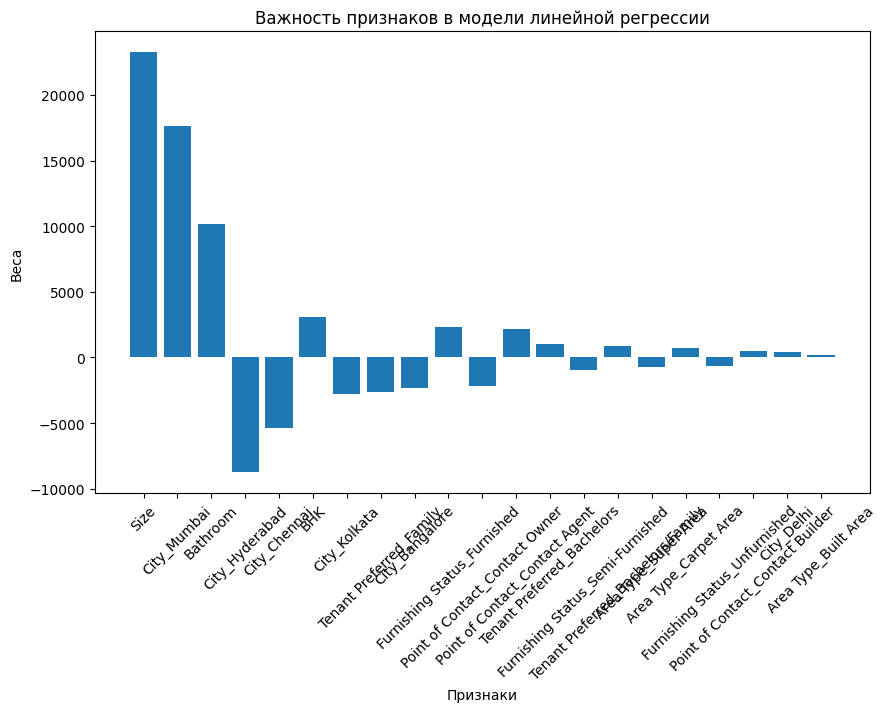

In [16]:
# Визуализация важности признаков
import matplotlib.pyplot as plt

# Сортировка признаков по убыванию важности
sorted_features = sorted(zip(features_to_use.columns, weights), key=lambda x: abs(x[1]), reverse=True)

# Разделение на имена признаков и их веса
sorted_feature_names, sorted_weights = zip(*sorted_features)

# Визуализация весов признаков
plt.figure(figsize=(10, 6))
plt.bar(sorted_feature_names, sorted_weights)
plt.title('Важность признаков в модели линейной регрессии')
plt.xlabel('Признаки')
plt.ylabel('Веса')
plt.xticks(rotation=45)
plt.show()

На графике видно, что наиболее весомыми признаками для определения стоимости аренды являются:
1. Общая площадь жилья
2. Город, в котором находится помещение
3. Кол-во ванных комнат
4. Общее кол-во комнат

### 2. Какая модель имеет наименьшее значение функции потерь на тестовой выборке? Помогает ли регуляризация избежать эффекта переобучения в данном примере?

Для сравнения эффективности двух моделей необходимо сравнить значения среднеквадратичных ошибок. В нашем случае MSE для обеих моделей практически идентичен:
- Для решения с помощью псевдообратной матрицы без регуляризации: 1911180916.2022083
- Для решения с помощью псевдообратной матрицы с L2 регуляризацией: 1911189769.349098
- Для решения методом градиентного спуска без регуляризациий: 1911180916.3190491
- Для решения методом градиентного спуска с L2 регуляризацией: 1911189769.4652529

Таким образом, мы можем сказать, что использование L2 регуляризации не приносит занчимого влияния на результаты.